# TABLES DES MATIERES


# 1) LIBRAIRIES  """""""""""""""""""""""""""""""""  Cell 1

# 2) INTRODUCTION """"""""""""""""""""""""Cells 2 to 10

# 3) Consolidation des données par Ordres"" Cells 11  to 26

# 3) Consolidation des données par Clients""  Cells 27 to 33

# 4) Problématique: Rétention """""""""""""" Cells  34 to 59       

# 5) Bibliographies """"""""""""""""""""""""" Cell 60

# 1) LIBRAIRIES

In [1]:
import pandas as pd
import unicodedata
import calendar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from plotnine import *
import matplotlib as mpl
import scipy.stats
mpl.rcParams['patch.force_edgecolor'] = True
%matplotlib inline

# 2) INTRODUCTION 

### Importer des tables

In [2]:
orders = pd.read_csv('olist_orders_dataset.csv', delimiter=",")
payment = pd.read_csv('olist_order_payments_dataset.csv', delimiter=",")
customers=  pd.read_csv('olist_customers_dataset.csv', delimiter=",")
sellers=  pd.read_csv('olist_sellers_dataset.csv', delimiter=",")
products=  pd.read_csv('olist_products_dataset.csv', delimiter=",")
reviews=  pd.read_csv('olist_order_reviews_dataset.csv', delimiter=",")
items=  pd.read_csv('olist_order_items_dataset.csv', delimiter=",")
geolocation=  pd.read_csv('olist_geolocation_dataset.csv', delimiter=",")
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

#### Vue d'ensemble de notre base de données: 

In [3]:
bdd = [orders, payment, customers,  sellers, products, reviews, items, product_category_name_translation]
titres = ["orders", "payment", "customers", "sellers","products","reviews","items","product_category_name_translation"]
info_df = pd.DataFrame({},)
info_df['bdd']= titres
info_df['dimensions']=[df.shape for df in bdd]
info_df['colonnes'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in bdd]
info_df['null_no']= [df.isnull().sum().sum() for df in bdd]
info_df['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in bdd]
info_df['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in bdd]


info_df.style.background_gradient(cmap='coolwarm')

,bdd,dimensions,colonnes,null_no,null_cols_no,null_cols
0,orders,"(99441, 8)","order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
1,payment,"(103886, 5)","order_id, payment_sequential, payment_type, payment_installments, payment_value",0,0,
2,customers,"(99441, 5)","customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",0,0,
3,sellers,"(3095, 4)","seller_id, seller_zip_code_prefix, seller_city, seller_state",0,0,
4,products,"(32951, 9)","product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
5,reviews,"(100000, 7)","review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",146532,2,"review_comment_title, review_comment_message"
6,items,"(112650, 7)","order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",0,0,
7,product_category_name_translation,"(71, 2)","product_category_name, product_category_name_english",0,0,


In [4]:
titres

['orders',
 'payment',
 'customers',
 'sellers',
 'products',
 'reviews',
 'items',
 'product_category_name_translation']

### La table "base" est composée de la jointure entre les tables ORDERS,CUSTOMERS ET PAYMENT. 

In [5]:
base = pd.merge(orders, customers, on='customer_id', how='left')
base = pd.merge(base, payment, on='order_id', how='left')

## Formating and Sanity

CONVERTISSEUR EN DATETIME

In [6]:
base['order_approved_at'] = pd.to_datetime(base['order_approved_at'], errors='coerce')
base['order_delivered_carrier_date'] = pd.to_datetime(base['order_delivered_carrier_date'], errors='coerce')
base['order_delivered_customer_date'] = pd.to_datetime(base['order_delivered_customer_date'], errors='coerce')
base['order_estimated_delivery_date'] = pd.to_datetime(base['order_estimated_delivery_date'], errors='coerce')
base['order_purchase_timestamp'] = pd.to_datetime(base['order_purchase_timestamp'], errors='coerce')

Convertisseur en Categorisation

In [7]:
cat_name1 = base['order_status'].unique().tolist()
cat_name2= base['customer_city'].unique().tolist()
cat_name3= base['customer_state'].unique().tolist()
base['order_status'] = pd.Categorical(base['order_status'], categories=cat_name1, ordered=False)
base['customer_city'] = pd.Categorical(base['customer_city'], categories=cat_name2, ordered=False)
base['customer_state'] = pd.Categorical(base['customer_state'], categories=cat_name3, ordered=False)

Ici, pour catégoriser la variable "payment_type", nous devons d'abord remplacer les valeurs Nan par 'not defined'. 

In [8]:
base['payment_type'] = base['payment_type'].replace(np.nan, 'not_defined')
cat_name4=base['payment_type'].unique().tolist()
base['payment_type'] = pd.Categorical(base['payment_type'], categories=cat_name4, ordered=False)

In [9]:
base.dtypes

order_id                                 object
customer_id                              object
order_status                           category
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                          category
customer_state                         category
payment_sequential                      float64
payment_type                           category
payment_installments                    float64
payment_value                           float64
dtype: object

In [10]:
def supprime_accent(ligne):
        """ supprime les accents du texte source """
        accent = ['é', 'è', 'ê', 'à', 'ù', 'û', 'ç', 'ô', 'î', 'ï', 'â']
        sans_accent = ['e', 'e', 'e', 'a', 'u', 'u', 'c', 'o', 'i', 'i', 'a']
        i = 0
        while i < len(accent):
            base['ligne'] = ligne.replace(accent[i], sans_accent[i])
            i += 1
        return ligne
base['customer_city'].apply(supprime_accent) 
base['customer_state'].apply(supprime_accent)

0         SP
1         SP
2         SP
3         BA
4         GO
          ..
103882    SP
103883    SP
103884    BA
103885    RJ
103886    PR
Name: customer_state, Length: 103887, dtype: category
Categories (27, object): ['SP', 'BA', 'GO', 'RN', ..., 'PI', 'AL', 'AC', 'AM']

# 3) Consolidation des données par ordre

### Tout d'abord, nous allons rajouter les variables "month", "year","day"," hour", et "month_year". 

In [11]:
base['month'] = base['order_purchase_timestamp'].dt.strftime('%m')
base['year'] =  base['order_purchase_timestamp'].dt.strftime('%Y')
base['day'] =  base['order_purchase_timestamp'].dt.strftime('%d')
base['hour'] = base['order_purchase_timestamp'].dt.strftime('%H')
base['year_month'] = base['order_purchase_timestamp'].dt.strftime('%Y-%m')

### Combien il y'a d'ordres par mois ?

<AxesSubplot:xlabel='month'>

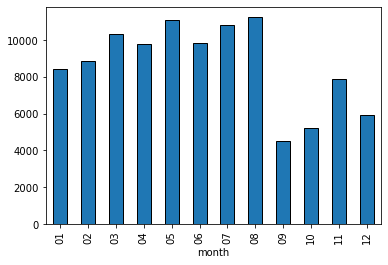

In [12]:
orders_per_months = base.groupby(base['month'])['order_id'].count()
orders_per_months.plot.bar()

Voici ci-dessus le nombre d'ordres par mois. C'est durant le mois d'aout qu'il y-en a le plus et c'est durant le mois suivant (septembre) qu'il y-en a le moins. 

### Combien de chiffre par mois ?

<AxesSubplot:xlabel='year_month'>

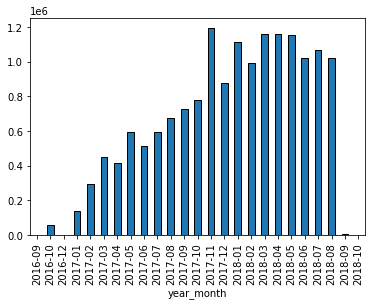

In [13]:
max_payment=base['payment_value'].max()
moyenne_payments=base['payment_value'].mean()
CA_per_months = base.groupby(base['year_month'])['payment_value'].sum()
CA_per_months.plot.bar()

C'est en novembre 2017 que l'on peut retrouver le chiffre d'affaire le plus élevé. 

In [14]:
print('CA moyen par mois:', CA_per_months.mean())
print('CA le pls élevé sur un mois:',CA_per_months.max())
print('Paiement record:', max_payment)
print('Paiement moyen:', moyenne_payments)

CA moyen par mois: 640354.8848
CA le pls élevé sur un mois: 1194882.7999999977
Paiement record: 13664.08
Paiement moyen: 154.10038041698772


### % d'ordres par heure

<AxesSubplot:>

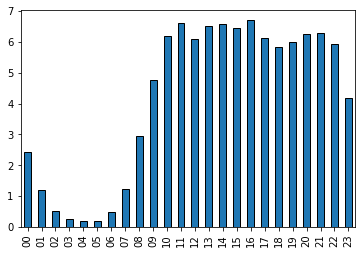

In [15]:
orders_per_hours = base['hour'].value_counts(normalize=True).sort_index()*100
orders_per_hours.plot.bar()

### % d'ordres par jour

<AxesSubplot:>

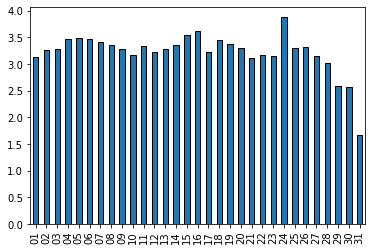

In [16]:
orders_per_day = base['day'].value_counts(normalize=True).sort_index()*100
orders_per_day.plot.bar()

### % de CA par jour ?

<AxesSubplot:xlabel='day'>

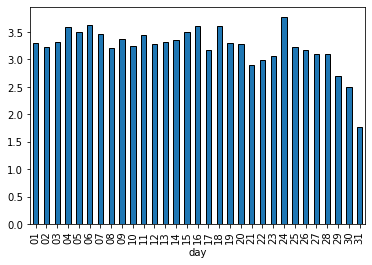

In [17]:
CA_per_days = pd.pivot_table(base, values=['payment_value'], index=['day'], aggfunc=np.sum)
CA_per_days['Pourcentage']= CA_per_days['payment_value'] / 16008872.12 *100
Somme_CA=CA_per_days.sum()
# Somme_CA = 16008872.12
CA_per_days['Pourcentage'].plot(kind='bar')

### % de CA par heure ?

<AxesSubplot:xlabel='hour'>

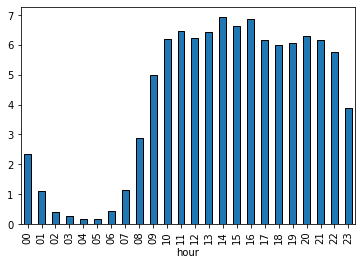

In [18]:
CA_per_days = pd.pivot_table(base, values=['payment_value'], index=['hour'], aggfunc=np.sum)
CA_per_days['Pourcentage']= CA_per_days['payment_value'] / 16008872.12 *100
Somme_CA=CA_per_days.sum()
# Somme_CA = 16008872.12
CA_per_days['Pourcentage'].plot(kind='bar')

In [19]:
### % de CA par heure ?

### Répartition des states par ordres

<AxesSubplot:ylabel='customer_state'>

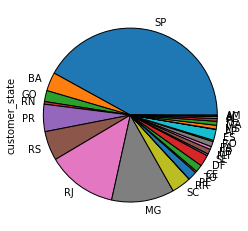

In [20]:
Ordres_par_states = pd.value_counts(base['customer_state']).sort_index() 
Ordres_par_states.plot.pie()

### Répartition des states par CA

<AxesSubplot:ylabel='payment_value'>

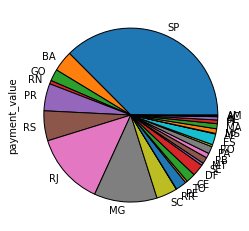

In [21]:
CA_par_states = base.groupby(['customer_state']).payment_value.sum()
CA_par_states.plot.pie()

### % d'ordres par moyen paiement par state

In [22]:
ordres_moyen_state = pd.crosstab(base['customer_state'], base['payment_type'], values=base['order_id'],
            aggfunc=pd.Series.count, normalize=True)

<AxesSubplot:xlabel='customer_state'>

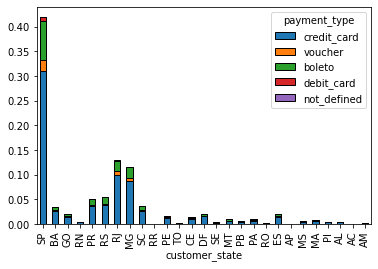

In [23]:
ordres_moyen_state.plot.bar(stacked=True)

### % de CA par moyen paiement par state

<AxesSubplot:xlabel='customer_state'>

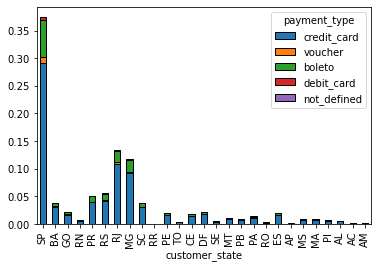

In [24]:
CA_moyen_state = pd.crosstab(base['customer_state'], base['payment_type'], values=base['payment_value'],
            aggfunc=pd.Series.sum, normalize=True)
CA_moyen_state.plot.bar(stacked=True)

### % d'ordres par moyen paiement par mois

<AxesSubplot:xlabel='year_month'>

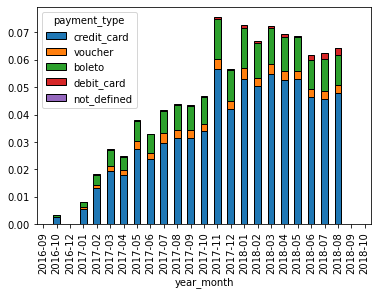

In [25]:
ordres_moyen_mois = pd.crosstab(base['year_month'], base['payment_type'], values=base['order_id'],
            aggfunc=pd.Series.count, normalize=True)
ordres_moyen_mois.plot.bar(stacked=True)

### % de CA par moyen paiement par mois

<AxesSubplot:xlabel='year_month'>

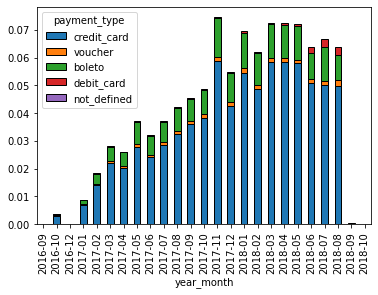

In [26]:
CA_par_mois_payment = pd.crosstab(base['year_month'], base['payment_type'], values=base['payment_value'],
            aggfunc=pd.Series.sum, normalize=True)
CA_par_mois_payment.plot.bar(stacked=True)

# 3) Consolidation des données par clients

### Nombre de commandes par client: 

In [27]:
Nb_commandes_par_clients = base.groupby(base['customer_id'])['order_id'].count()
Paiements_par_clients = base.groupby(['customer_id'])['payment_value'].sum()
print('Les clients passent en général une seule commande.    :', Nb_commandes_par_clients.mean())
print('Le record de commandes d un seul client.              :', Nb_commandes_par_clients.max())
print('La dépense moyenne d un client                        :', Paiements_par_clients.mean())
print('La dépense record pour un seul client.                :', Paiements_par_clients.max())

Les clients passent en général une seule commande.    : 1.0447099285003167
Le record de commandes d un seul client.              : 29
La dépense moyenne d un client                        : 160.98864774086096
La dépense record pour un seul client.                : 13664.08


#### Voici notre nouvelle base client: 

In [28]:
Nouvelle_base_client=pd.merge(customers,Nb_commandes_par_clients, on='customer_id')
Nouvelle_base_client=pd.merge(Nouvelle_base_client, Paiements_par_clients, on='customer_id')
Client_prop=Nouvelle_base_client.rename(columns={'order_id': 'Nb_de_commandes'})
Client_prop.drop(['customer_unique_id','customer_zip_code_prefix'], axis=1)

,customer_id,customer_city,customer_state,Nb_de_commandes,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,1,146.87
1,18955e83d337fd6b2def6b18a428ac77,sao bernardo do campo,SP,1,335.48
2,4e7b3e00288586ebd08712fdd0374a03,sao paulo,SP,1,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,mogi das cruzes,SP,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,campinas,SP,1,252.25
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,sao paulo,SP,1,88.78
99437,e7b71a9017aa05c9a7fd292d714858e8,taboao da serra,SP,1,129.06
99438,5e28dfe12db7fb50a4b2f691faecea5e,fortaleza,CE,1,56.04
99439,56b18e2166679b8a959d72dd06da27f9,canoas,RS,1,711.07


### La distribution des paiements et du nombre de commandes par client suit une loi normale

In [29]:
print('VALEUR PAIEMENT ---------------' ,scipy.stats.normaltest(Client_prop.payment_value))
print('NB de commandes ---------------' ,scipy.stats.normaltest(Client_prop.Nb_de_commandes))

VALEUR PAIEMENT --------------- NormaltestResult(statistic=151793.70302269488, pvalue=0.0)
NB de commandes --------------- NormaltestResult(statistic=235859.39433414355, pvalue=0.0)


Nb_de_commandes       AxesSubplot(0.125,0.125;0.352273x0.755)
payment_value      AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

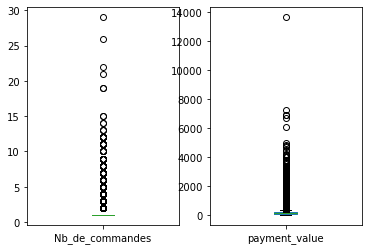

In [30]:
Client_prop[['Nb_de_commandes','payment_value']].plot(kind='box', subplots=True, sharex=True)

### Classement des 15 villes où résident le plus de clients

Les habitants de Saopaulo représentent 15% des clients avec un total de 15 540 personnes. 

In [31]:
Client_prop['customer_city'].value_counts().head(15)


sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
niteroi                    849
santo andre                797
osasco                     746
santos                     713
goiania                    692
Name: customer_city, dtype: int64

<AxesSubplot:ylabel='customer_city'>

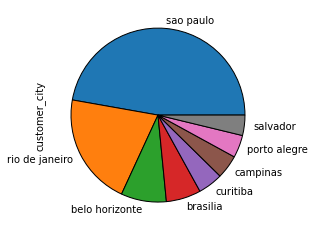

In [32]:
Client_prop['customer_city'].value_counts().head(8).plot(kind='pie')

### Classement des 4 pays où résident le plus de clients

C:\Users\USER\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


<AxesSubplot:ylabel='customer_state'>

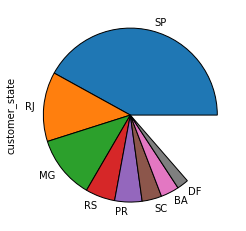

In [33]:
State=Client_prop['customer_state'].value_counts(normalize=True).head(8)
State.plot(kind='pie')

1) SP: Sao Paulo 2) RJ: Rio de Janeiro 3) MG: Minas Gerais 4) RS:Rio Grande do Sul 5) PR: Parana

# 4) Problématique: Rétention 

### Recency, Frequency, Monetary Value (RFM)

Recency=Intervalle

Frequency=Frequence

Monetary Value= Somme totale

Ces termes seront expliqués au fur et à mesure. Nous créerons par la suite un score RFM afin de permettre la segmentation des clients

Tout d'abord, nous allons combiner les paiements pour un même client:

In [34]:
payment_par_clients=base[['customer_id','payment_value']].groupby('customer_id')['payment_value'].sum().reset_index()

Ici, la fréquence représente le nombre de commande par un même client. 

In [35]:
frequence = pd.DataFrame(base.groupby('customer_id')['order_id'].count())

Intervalle représente la distance en jours entre la dernière transaction du client et la dernière transaction enregistré dans notre base. 

In [36]:
dernière_transaction=pd.DataFrame(base.groupby('customer_id')['order_purchase_timestamp'].max())
dernière_transaction['intervalle']=dernière_transaction['order_purchase_timestamp'].max()-dernière_transaction['order_purchase_timestamp']
dernière_transaction['intervalle']=dernière_transaction['intervalle'].dt.days

In [37]:
first=pd.merge(payment_par_clients,frequence,on='customer_id')
pfdt=pd.merge(first,dernière_transaction,on='customer_id')
pfdt.drop(['order_purchase_timestamp'],axis=1,inplace=True)
pfdt.columns=['Client_unique','Somme_totale','Fréquence','Intervalle']
pfdt

,Client_unique,Somme_totale,Fréquence,Intervalle
0,00012a2ce6f8dcda20d059ce98491703,114.74,1,337
1,000161a058600d5901f007fab4c27140,67.41,1,458
2,0001fd6190edaaf884bcaf3d49edf079,195.42,1,596
3,0002414f95344307404f0ace7a26f1d5,179.35,1,427
4,000379cdec625522490c315e70c7a9fb,107.01,1,198
...,...,...,...,...
99436,fffecc9f79fd8c764f843e9951b11341,81.36,3,202
99437,fffeda5b6d849fbd39689bb92087f431,63.13,1,148
99438,ffff42319e9b2d713724ae527742af25,214.13,1,126
99439,ffffa3172527f765de70084a7e53aae8,45.50,1,410


In [38]:
habitués_mask= pfdt['Fréquence'] > 1
non_habitués_mask = pfdt['Fréquence'] == 1
habitués_mask.describe()

count     99441
unique        2
top       False
freq      96480
Name: Fréquence, dtype: object

### Seulement 3% des clients font plus d'un achat

In [39]:
(1-(96480/99441))*100

2.977645035749843

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


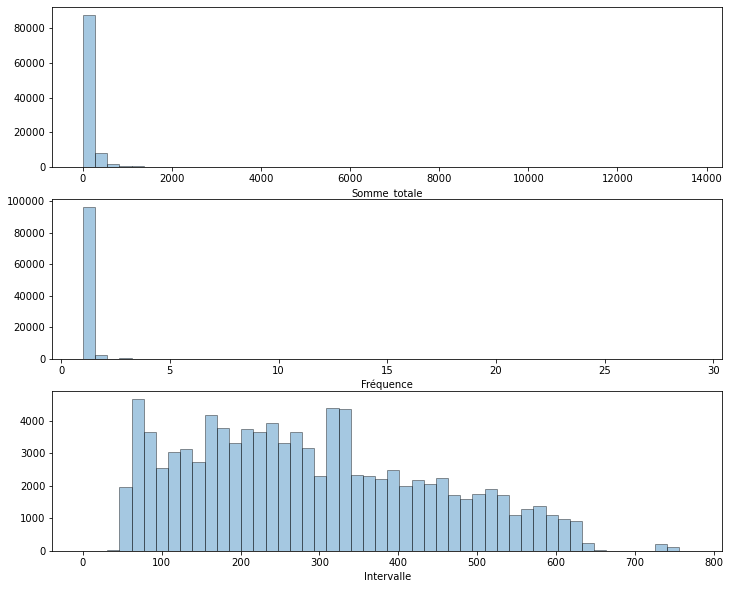

In [40]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(pfdt['Somme_totale'],kde=False)
plt.subplot(3, 1, 2); sns.distplot(pfdt['Fréquence'],kde=False)
plt.subplot(3, 1, 3); sns.distplot(pfdt['Intervalle'],kde=False)
plt.show()

In [41]:
describe=['Somme_totale','Fréquence','Intervalle']
pfdt[describe].describe(percentiles=[ .01 , .1, .5, .9, .99 ])

,Somme_totale,Fréquence,Intervalle
count,99441.000000,99441.000000,99441.000000
mean,160.988648,1.044710,289.900192
std,221.950728,0.381164,153.667316
min,0.000000,1.000000,0.000000
1%,22.380000,1.000000,57.000000
10%,39.600000,1.000000,91.000000
50%,105.290000,1.000000,271.000000
90%,308.240000,1.000000,518.000000
99%,1075.794000,2.000000,625.000000
max,13664.080000,29.000000,772.000000


#### Le panier moyen est de 160 pour une seule opération. Seulement 10% des clients ont dépensé plus de 310 unités de prix.  Il se passe 289 jours en moyenne entre le dernier achat d'un client et aujourd'hui. Seulement 1% des clients réitèrent leur achat en moins de 57 jours. 

#### Nous pouvons maintenant créer un score pour chaque client. 

In [42]:
quantiles = pfdt.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Somme_totale': {0.25: 62.01, 0.5: 105.29, 0.75: 176.97},
 'Fréquence': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Intervalle': {0.25: 166.0, 0.5: 271.0, 0.75: 400.0}}

In [43]:
# Soit x le score, p les attributs du client et d le quartile associé.
def RScore(x,p,d): #RecencyScore
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# k représente quartile associé aux quartiles de fréquence et monetary associés. 
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [44]:
#create rfm segmentation table
rfm_segmentation = pfdt
rfm_segmentation['R_Quartile'] = rfm_segmentation['Intervalle'].apply(RScore, args=('Intervalle',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Fréquence'].apply(FMScore, args=('Fréquence',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Somme_totale'].apply(FMScore, args=('Somme_totale',quantiles,))
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Client_unique,Somme_totale,Fréquence,Intervalle,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,00012a2ce6f8dcda20d059ce98491703,114.74,1,337,2,1,3,213
1,000161a058600d5901f007fab4c27140,67.41,1,458,1,1,2,112
2,0001fd6190edaaf884bcaf3d49edf079,195.42,1,596,1,1,4,114
3,0002414f95344307404f0ace7a26f1d5,179.35,1,427,1,1,4,114
4,000379cdec625522490c315e70c7a9fb,107.01,1,198,3,1,3,313


### Combien de clients pour chaque segmentation

In [45]:
print("Meilleurs clients: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Clients récurrents: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Clients dépensiers: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Clients bientôt perdus: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Meilleurs Clients perdus',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Clients passagers peu importants: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Meilleurs clients:  183
Clients récurrents:  2961
Clients dépensiers:  24859
Clients bientôt perdus:  181
Meilleurs Clients perdus 197
Clients passagers peu importants:  6171


### Le concept de la RFM segmentation a été pensé par Jan Roelf et Tom Wansbeek. Dans l'article "Optimal Selection for Direct Mail" paru en 1995 dans la revue Marketing Science, ils expliquent que 80% de l'activité repose sur 20% de clients concernés. Voici donc la liste des clients sur lesquels nous devons porter une attention particulière: 

### Voici la liste des clients que l'on considerera VIP. Ces clients ont le meilleur score. Nous pouvons leur proposer un bon d'achat. Ils représentent moins de 1% de la clientèle. 

In [46]:
df=rfm_segmentation
Clients_VIP= df.loc[df.RFMScore=='444']
List_Clients_VIP=Clients_VIP['Client_unique'].tolist()

### Voici la liste des clients que l'on considerera comme dépensiers. Ces clients ont un score de 4 en Monetary. Ils sont 24 859 au total ( 25% de la clientèle ). Cependant, ils ont dépensé à hauteur de 9 493 956. Cette somme représente plus de 50 % des dépenses totales.

In [47]:
Clients_dépensiers = df.loc[df.M_Quartile==4]
#Clients_dépensiers['Somme_totale'].sum() = 9 493 956
#df['Somme_totale'].sum() = 16 008 872.12
List_clients_dépensiers=Clients_dépensiers['Client_unique'].tolist()


### Pour finir, voici la liste des clients que l'on considerera comme récurrents. Ces clients ont un score de 4 en Frequency. Ils sont 2 961 au total ( 3% de la clientèle ) et représentent 7% des transactions totales. Il faut inciter ces clients à réiterer leurs achats, par exemple à travers un programme de fidélité. 

In [59]:
Clients_récurrents = df.loc[df.F_Quartile==4]
#Clients_récurrents['Fréquence'].sum()= 7 407
# df['Fréquence'].sum() 103 887
# 7407/103887 = 7,12%.
List_clients_dépensiers=Clients_dépensiers['Client_unique'].tolist()

# BIBLIOGRAPHIE

Vous pourrez trouver la ittérature concernant le RFM score sur ces pages: 
    
https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp#:~:text=Recency%2C%20frequency%2C%20monetary%20value%20is,a%20customer%20makes%20a%20purchase

https://www.e-marketing.fr/Thematique/academie-1078/fiche-outils-10154/scoring-RFM-306775.htm

https://www.cartelis.com/blog/segmentation-rfm-definition-calcul/

Notebooks qui m'ont été utiles:

https://www.kaggle.com/ashikm96/e-commerce-analysis-olist-data
    
https://www.kaggle.com/pigortekids/predicting-score-from-commentaries-in-e-commerce